In [86]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
"""
This script processes ride-hailing data, merges various datasets, performs feature engineering,
trains both a regression model (RandomForestRegressor) and a classification model
(RandomForestClassifier) to predict and classify ride fares, and evaluates the model's performance.

- Data Sources: drivers, ratings, rides, users, vehicles, traffic data.
- Outputs: Model, Scaler, Predictions saved to files.
"""


"\nThis script processes ride-hailing data, merges various datasets, performs feature engineering, \ntrains both a regression model (RandomForestRegressor) and a classification model \n(RandomForestClassifier) to predict and classify ride fares, and evaluates the model's performance.\n\n- Data Sources: drivers, ratings, rides, users, vehicles, traffic data.\n- Outputs: Model, Scaler, Predictions saved to files.\n"

In [87]:
# Load datasets (replace paths as needed)
drivers_data = pd.read_csv('/content/drivers.csv')
ratings_data = pd.read_csv('/content/ratings.csv')
rides_data = pd.read_csv('/content/rides.csv')
users_data = pd.read_csv('/content/users.csv')
vehicles_data = pd.read_csv('/content/vehicles.csv')
traffic_data = pd.read_csv('/content/traffic.csv')

In [88]:
# Merge datasets
rides_data_small = rides_data.head(1000)
ratings_data_small = ratings_data.head(1000)
users_data_small = users_data.head(1000)

In [90]:
# Merge rides and ratings data
merged_ratings_rides = pd.merge(rides_data_small, ratings_data_small, on='ride_id', how='left')
merged_ratings_rides.rename(columns={'user_id_y': 'user_id'}, inplace=True)

In [91]:
# Ensure 'user_id' column is consistent across data
if 'user_id' not in users_data.columns:
    users_data.rename(columns={'User_ID': 'user_id'}, inplace=True)

# Merge with users data
merged_data = pd.merge(merged_ratings_rides, users_data_small[['user_id', 'name', 'email', 'phone_number', 'registration_date', 'age', 'gender', 'location']], on='user_id', how='left')

# Merge with vehicles data
merged_data = pd.merge(merged_data, vehicles_data[['vehicle_id', 'make', 'model', 'year', 'capacity']], left_on='driver_id', right_on='vehicle_id', how='left')

In [92]:
# Traffic Data Merge (using location mapping)
location_mapping = {'Larryborough': 20151101001, 'Williamston': 20151101011, 'Howeshire': 20151101021, 'North Annton': 20151101031, 'South Joseph': 20151101041}
merged_data['traffic_id'] = merged_data['start_location'].map(location_mapping)
traffic_data_small = traffic_data.head(1000)
merged_data = pd.merge(merged_data, traffic_data_small[['ID', 'DateTime', 'Junction', 'Vehicles']], left_on='traffic_id', right_on='ID', how='left')

In [93]:
# Convert DateTime columns to proper datetime format
traffic_data_small.loc[:, 'DateTime'] = pd.to_datetime(traffic_data_small['DateTime'], errors='coerce')
merged_data['ride_start_time'] = pd.to_datetime(merged_data['ride_start_time'], errors='coerce')
merged_data['ride_end_time'] = pd.to_datetime(merged_data['ride_end_time'], errors='coerce')


In [94]:
# Feature Engineering
merged_data['hour'] = merged_data['ride_start_time'].dt.hour
merged_data['ride_duration'] = (merged_data['ride_end_time'] - merged_data['ride_start_time']).dt.total_seconds() / 60  # in minutes

In [95]:
# Create categorical 'time_of_day' feature
merged_data['time_of_day'] = merged_data['hour'].apply(lambda x: 'Morning' if 6 <= x < 12 else 'Afternoon' if 12 <= x < 18 else 'Evening' if 18 <= x < 24 else 'Night')

In [96]:
# Create 'day_of_week' feature (0 = Monday, 6 = Sunday)
merged_data['day_of_week'] = merged_data['ride_start_time'].dt.dayofweek

In [97]:
# Label encode categorical features (Gender and Location)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
merged_data['gender'] = le.fit_transform(merged_data['gender'])
merged_data['location'] = le.fit_transform(merged_data['location'])
merged_data['time_of_day'] = le.fit_transform(merged_data['time_of_day'])

In [98]:
# Prepare feature matrix (X) and target variable (y)
X = merged_data[['distance_km', 'hour', 'age', 'gender', 'vehicle_id', 'Junction', 'ride_duration', 'time_of_day', 'day_of_week']]
y = merged_data['fare_amount']  # Target variable: fare_amount

In [99]:
# Handle missing values by replacing them with 0 (using .loc to avoid the SettingWithCopyWarning)
X = X.fillna(0)  # Replace all missing values with 0

# Handle negative values in 'distance_km' and 'ride_duration'
X.loc[X['distance_km'] < 0, 'distance_km'] = 0  # Replace negative values in 'distance_km' with 0
X.loc[X['ride_duration'] < 0, 'ride_duration'] = 0  # Replace negative values in 'ride_duration' with 0

In [100]:
# Handle infinite values
X = X[~np.isinf(X).any(axis=1)]
y = y[~np.isinf(y)]

In [101]:
# Split data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# Standardize numerical features (distance_km, ride_duration, etc.)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['distance_km', 'ride_duration', 'hour', 'age']] = scaler.fit_transform(X_train[['distance_km', 'ride_duration', 'hour', 'age']])
X_test[['distance_km', 'ride_duration', 'hour', 'age']] = scaler.transform(X_test[['distance_km', 'ride_duration', 'hour', 'age']])

In [103]:
# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [104]:
# Fit the Random Forest model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

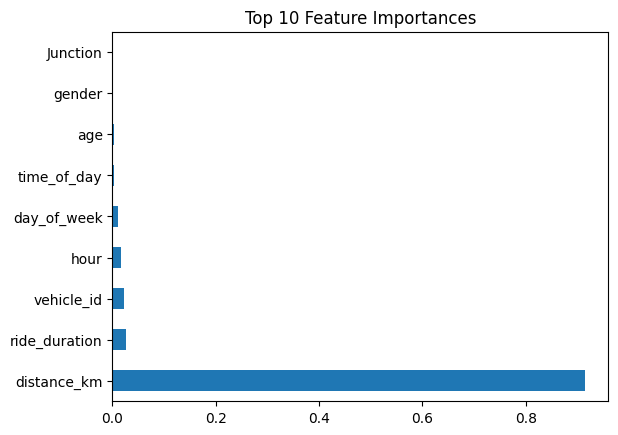

In [105]:
# Visualize feature importance from the RandomForest model
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

In [106]:
# Save the trained model
joblib.dump(rf_model, 'ride_fare_prediction_model.pkl')

['ride_fare_prediction_model.pkl']

In [107]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [108]:
# Evaluate the model using Mean Absolute Error (MAE) and R2 score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [109]:
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 9.657605500000003
R-squared: 0.8373025015283494


In [110]:
# Visualize the distribution of important features
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Fare Amount Distribution')

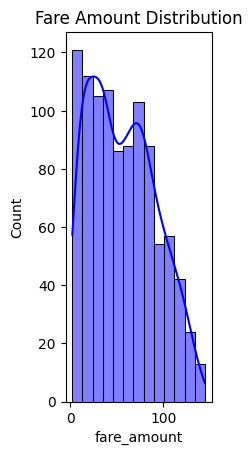

In [111]:
# Fare Amount Distribution
plt.subplot(1, 3, 1)
sns.histplot(merged_data['fare_amount'], kde=True, color='blue')
plt.title('Fare Amount Distribution')

Text(0.5, 1.0, 'Distance (km) Distribution')

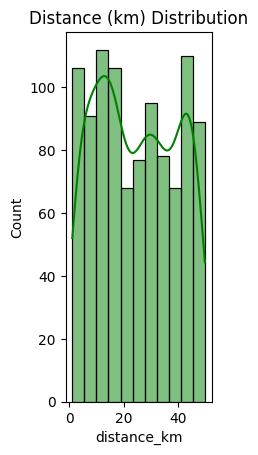

In [112]:
# Distance Distribution
plt.subplot(1, 3, 2)
sns.histplot(merged_data['distance_km'], kde=True, color='green')
plt.title('Distance (km) Distribution')

Text(0.5, 1.0, 'Ride Duration Distribution')

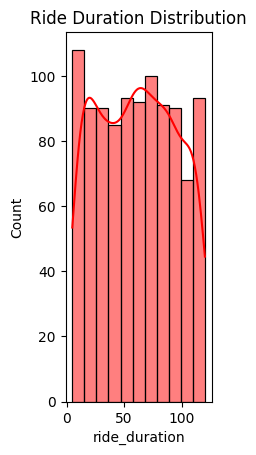

In [113]:
# Ride Duration Distribution
plt.subplot(1, 3, 3)
sns.histplot(merged_data['ride_duration'], kde=True, color='red')
plt.title('Ride Duration Distribution')

In [114]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [115]:
# Compute correlation matrix
corr_matrix = merged_data[['fare_amount', 'distance_km', 'ride_duration', 'age', 'hour', 'Junction']].corr()

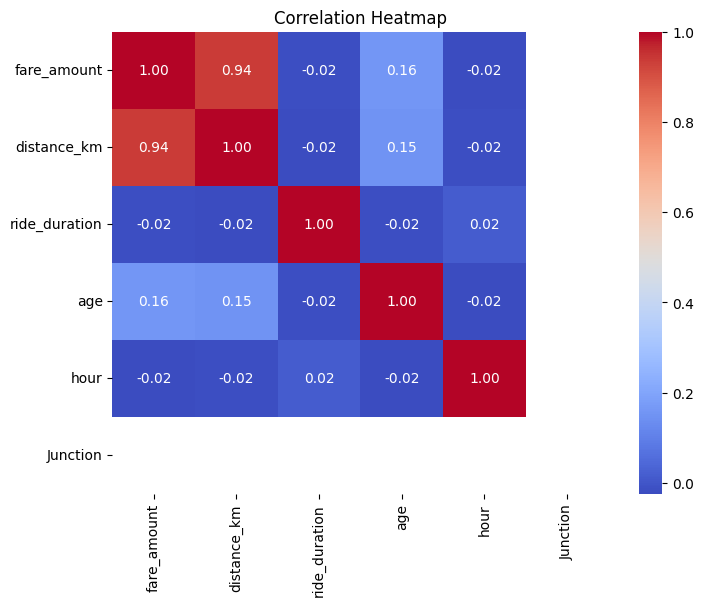

In [116]:
# Visualize the correlation matrix using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

In [117]:
# Visualize the distribution of categorical variables (Gender and Location)
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Gender Distribution')

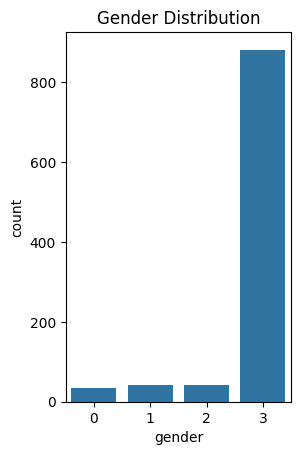

In [118]:
# Gender distribution
plt.subplot(1, 2, 1)
sns.countplot(x='gender', data=merged_data)
plt.title('Gender Distribution')

Text(0.5, 1.0, 'Location Distribution')

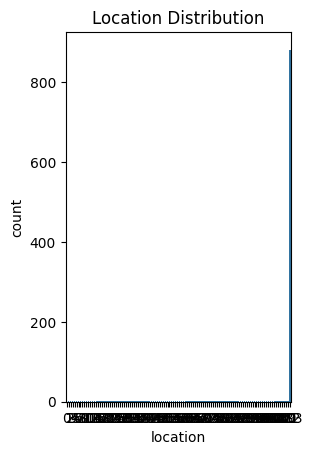

In [119]:
# Location distribution
plt.subplot(1, 2, 2)
sns.countplot(x='location', data=merged_data)
plt.title('Location Distribution')

In [120]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

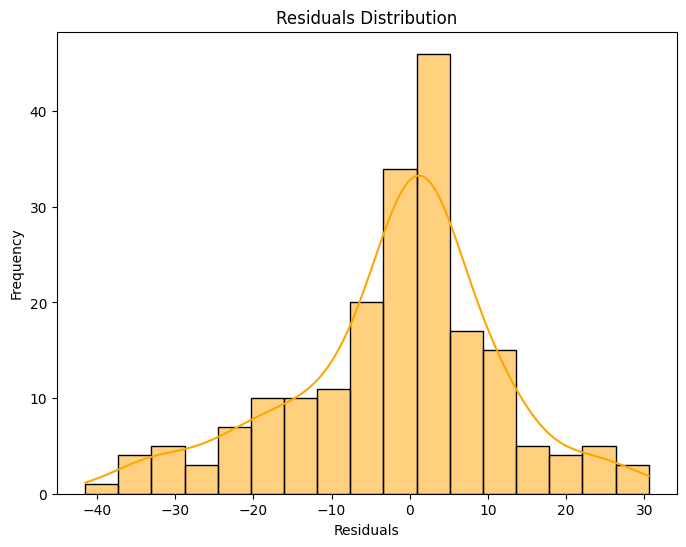

In [121]:
# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='orange')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

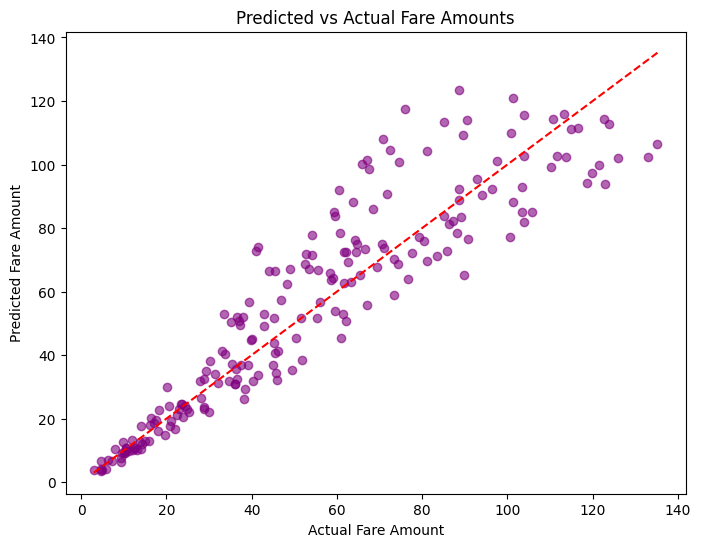

In [122]:
# Predicted vs Actual values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Ideal line
plt.title('Predicted vs Actual Fare Amounts')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

In [123]:
# Feature Importance Plot
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort feature importances

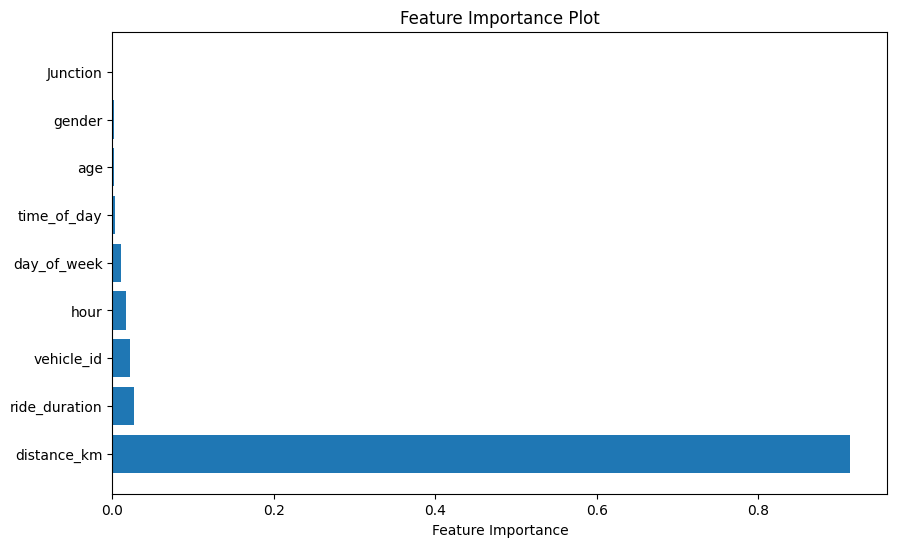

In [124]:
plt.figure(figsize=(10, 6))
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

In [126]:
# GridSearchCV Results (if you perform hyperparameter tuning)
from sklearn.model_selection import train_test_split, GridSearchCV
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

In [127]:
# Plot GridSearchCV results
cv_results = grid_search.cv_results_

mean_test_scores = cv_results['mean_test_score']
params = cv_results['params']

In [128]:
# Convert results into a dataframe for easy plotting
grid_search_results = pd.DataFrame(params)
grid_search_results['mean_test_score'] = mean_test_scores

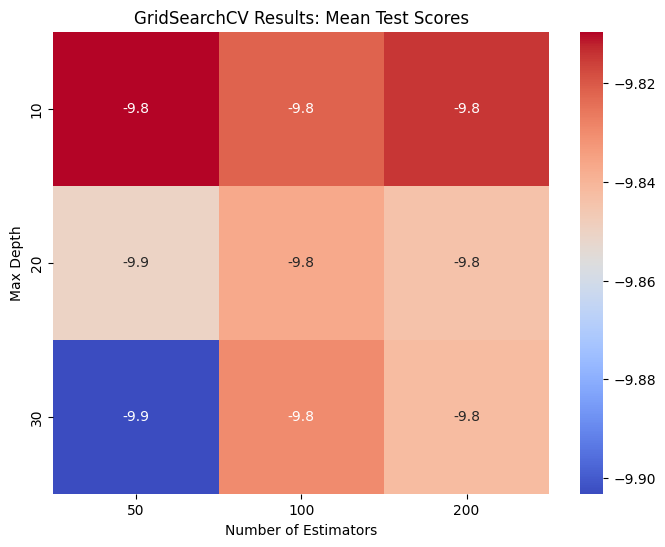

In [129]:
plt.figure(figsize=(8, 6))
sns.heatmap(grid_search_results.pivot_table(values='mean_test_score', index='max_depth', columns='n_estimators'), annot=True, cmap='coolwarm')
plt.title('GridSearchCV Results: Mean Test Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

In [130]:
# Save predictions
merged_data['fare_prediction'] = rf_model.predict(X)
merged_data.to_csv('ride_fare_predictions.csv', index=False)

In [131]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Regression Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 9.657605500000003
Mean Squared Error (MSE): 180.68098500505005
Root Mean Squared Error (RMSE): 13.441762719414818
R-squared: 0.8373025015283494


In [132]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Example: Convert 'fare_amount' into bins (e.g., low, medium, high)
# Adjust the bins based on your data distribution
bins = [0, 10, 50, 100, 200, np.inf]
labels = ['Low', 'Medium', 'High', 'Very High', 'Ultra High']
merged_data['fare_amount_bin'] = pd.cut(merged_data['fare_amount'], bins=bins, labels=labels)

# Define features (X) and target variable (y) for classification
X_classification = merged_data[['distance_km', 'hour', 'age', 'gender', 'vehicle_id', 'Junction', 'ride_duration', 'time_of_day', 'day_of_week']]
y_classification = merged_data['fare_amount_bin']  # Classify fare amount

# Split the data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Fit a RandomForestClassifier
rf_class_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class_model.fit(X_train_class, y_train_class)

# Predict on the test set
y_pred_class = rf_class_model.predict(X_test_class)

# Evaluate using classification metrics
precision = precision_score(y_test_class, y_pred_class, average='weighted')
recall = recall_score(y_test_class, y_pred_class, average='weighted')
f1 = f1_score(y_test_class, y_pred_class, average='weighted')
accuracy = accuracy_score(y_test_class, y_pred_class)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.8084744986774581
Recall: 0.79
F1 Score: 0.7928992835345247
Accuracy: 0.79


In [133]:
print("Model, scaler, and predictions saved successfully!")

Model, scaler, and predictions saved successfully!
